<a href="https://colab.research.google.com/github/pooji0401/Text-Analysis/blob/master/fake_news/ML_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pwd

/content


In [3]:
##imports
import re, string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# https://gist.github.com/sebleier/554280
with open('data/stop_words_file.txt','r') as f:
  lines = f.readlines()
lines = list(map(lambda x:x.strip(), lines))

## stop_words
stop_words = list(stop_words)+lines
stop_words = set(stop_words)

In [5]:
df_fake = pd.read_csv('data/Fake.csv',engine='python',error_bad_lines=False)
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_true = pd.read_csv('data/True.csv',engine='python',error_bad_lines=False)
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data Preprocessing and Feature Engineering
Generally, for any predictive modelling task, before we fit our model  we clean our data -  remove nulls check for any class imbalance in the data.  </n>

For text analysis, each word (or combination of words) acts like feature, thereby resulting in <b> curse of dimensionality reduction </b>. Therefore, cleaning text is an essential step. There is no hard and fast rule about this process. It generally depends on the domain of the application. For example, in some cases, we completely convert the text to lower case where the Capitalisation doesn't play any major role. In the case of Spam words, where most of the text is captilised, Another interesting example in this scenario would be the punctuation marks. In most of the spam msgs, there are a lot of punctuation marks like '!','*',etc. Hence, there are various permutations of such techniques to clean the text. 

Interestingly, we can derive more features from text before preprocessing. This can include the count of specific punctuation marks, or even sentiment scores - polarity/subjectivity scores.

</n>

In this example, we are going to implement some basic preprocessing steps and establish a baseline for our analysis. 

### Checking for nulls

In [7]:
df_true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Since every peice of text in the True news contains the source (Reuters), it is essential to remove this from the text in order to remove the bias from the text.

In [9]:
# s = 0
# for i in range(len(df_true)):
#   if ') -' not in df_true['text'].iloc[i]:
#     print(i)
#     s+=1
# print(s)

In [10]:
df_true['text'].iloc[17871]

'MADRID - Catalan regional leader Carles Puigdemont planned on Tuesday to address a session of the regional parliament that might adopt a unilateral declaration of independence from Spain.  Below are the main points of the Catalan legal framework that permitted the Oct. 1 referendum on independence and would underpin a new state before a constitution is established. Spain s Constitutional Court has suspended the new laws. WHAT DOES LEGISLATION SAY ABOUT DECLARATION OF INDEPENDENCE? Legislation passed in the Catalan parliament on Sept. 6 states that the outcome of the referendum is binding, and if it produces more affirmative than negative votes, this implies the independence of Catalonia.  Within two days of the official announcement of the result of the referendum, the Catalan parliament will formally declare independence, explain the effects of the decision and start the process of founding a republic.                  The legislation describes Catalonia as  a social and democratic r

In [11]:
def remove_source(x):
  if ') -' in x:
    return x.split(') -')[1].strip()
  else:
    return x

df_true['text'] = df_true['text'].apply(lambda x:remove_source(x))
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"


In [12]:
df_fake['label'] = [1]*len(df_fake)
df_true['label'] = [0]*len(df_true)
df_fake['num_words'] = df_fake['text'].apply(lambda x: len(x.split()))
df_true['num_words'] = df_true['text'].apply(lambda x: len(x.split()))

### Checking for class imbalance and length imbalance

Length imbalance in this case refers to the significant difference in the length of means of both classes of examples. We want the model to work equally good with lengthy sentences for both classes. 

In order to balance out the lengths, we remove the extremes in both classes - above 75th percentile (too long sentences) and below 25th percentile(too short sentences).  

In [13]:
df_explore_words = pd.DataFrame(df_fake['num_words'].describe()).rename({'num_words':'fake_words'},axis=1)
df_explore_words['True_words'] = df_true['num_words'].describe()
df_explore_words

,fake_words,True_words
count,23481.000000,21417.000000
mean,423.197905,381.224821
std,408.388890,273.629815
min,0.000000,0.000000
25%,240.000000,143.000000
50%,363.000000,355.000000
75%,506.000000,519.000000
max,8135.000000,5170.000000


In [14]:
df_fake = df_fake[(df_fake['num_words']>=240)&(df_fake['num_words']<=506)]
df_true = df_true[(df_true['num_words']>=143)&(df_true['num_words']<=519)]
len(df_fake),len(df_true)

(11772, 10734)

In [15]:
df_total = pd.concat([df_fake,df_true],axis=0)
df_total.head()

,title,text,subject,date,label,num_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,305
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,420
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,312


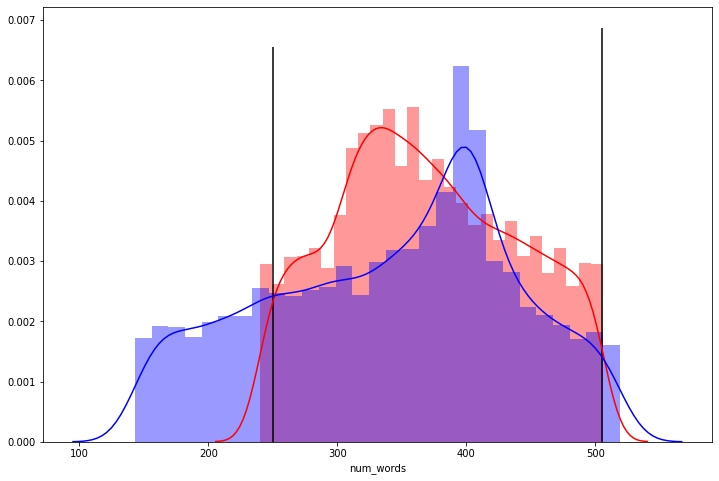

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
# plt.figure()
sns.distplot(df_total[df_total['label']==1]['num_words'],color='red')
sns.distplot(df_total[df_total['label']==0]['num_words'],color='blue')
ax.vlines(250,*ax.get_ylim())
ax.vlines(505,*ax.get_ylim())

We want to take the sequences with nearly same number of words in both the cases. As you can see, the common set of sentences have a range of 250 - 500 words.

In [17]:
df_total = df_total[(df_total['num_words']>=250)&(df_total['num_words']<=505)]

Finally, we rebalance the number of records across both the classes.

In [18]:
def rebalance_data(df):
    label_0_len = len(df[df['label']==0])
    label_1_len = len(df[df['label']==1])
    min_len = min(label_0_len,label_1_len)

    df_new_lab1 = df[df['label']==1].sample(min_len)
    df_new_lab0 = df[df['label']==0].sample(min_len)

    df=pd.concat([df_new_lab0,df_new_lab1])
    df.reset_index(inplace=True,drop=True)
    print('Total num of records after balancing ',len(df))
    return df

In [19]:
df_total = rebalance_data(df_total)

Total num of records after balancing  16408


In [20]:
df_total.label.value_counts()

1    8204
0    8204
Name: label, dtype: int64

In [21]:
df_total.head()

,title,text,subject,date,label,num_words
0,Australia police arrest man accused of plottin...,Police have arrested a 20-year-old man suspect...,worldnews,"November 27, 2017",0,326
1,U.S. House committee votes to smooth e-cigaret...,A U.S. House of Representatives committee on T...,politicsNews,"April 19, 2016",0,478
2,Trump creates business advisory council stacke...,President-elect Donald Trump announced the for...,politicsNews,"December 2, 2016",0,384
3,Thai monks receive alms to mark a year since d...,Thailand on Friday held a nationwide Buddhist ...,worldnews,"October 13, 2017",0,333
4,Senate sets votes on competing Zika funding plans,Three competing plans for battling a potential...,politicsNews,"May 12, 2016",0,457


In [22]:
df_final = df_total[['text','label']]
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,text,label
0,Police have arrested a 20-year-old man suspect...,0
1,A U.S. House of Representatives committee on T...,0
2,President-elect Donald Trump announced the for...,0
3,Thailand on Friday held a nationwide Buddhist ...,0
4,Three competing plans for battling a potential...,0


### Text Cleaning 
The steps followed for this step are as follows - 
1. Removing trailing white spaces
2. Removing punctuations
3. Removing stop words
4. Lemmatize the word to the verb level 
5. Removing all the proper nouns in the sentence using POS tagger
6. Converting the final filtered sentence to lower case

Note that, For step 5 (filtering nouns) Casing is very important in order to identify the nouns and any other tags. Therefore, it is the last step in our cleaning pipeline. Therefore, the order of these steps is also very important and specific to out application

In [23]:
def clean_lemma_text_blob(x):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    ## Removing Stop Words, Lemmatizing using Text Blob
    #     x = x.lower() ## Lower Case Conversion
    x = x.strip()
    x = regex.sub('', x) ## Removing Punctuations
    word_tokens = x.split()
    filtered_sentence = [Word(i.lower()).lemmatize("v") for i in word_tokens if not i in stop_words] 
    filtered_sentence = ' '.join(filtered_sentence)
    if(len(filtered_sentence.split())>0):
        p_blob = TextBlob(filtered_sentence)
        m = np.array(p_blob.tags)
#         m = m[(m[:,1]=='NN') | (m[:,1] =='JJ') | (m[:,1] =='VBP') | (m[:,1] =='VB') ]
        m = m[~(m[:,1]=='NN')]
        filtered_sentence = ' '.join(m[:,0])
        filtered_sentence = filtered_sentence.lower()
        return filtered_sentence
    else:
        return ''
    

In [24]:
def clean_text_df(df):
    df['text_noun_cleaned']=df['text'].apply(lambda x: clean_lemma_text_blob(x))
    return df

### Feature Engineering 

In this case, we are adding sentiment features - polarity and subjectivity scores using Text Blob package. 

<b>Polarity</b> indicates the tone of the sentence - postive, neutral and negative. The scores are in the range of [-1,+1]. <b>Subjectivity</b> indicates how the subject is addressed in the sentence. The scores are in the range [0,1]

Finally, we use the <b>Term-Frequency-Inverse-Document-Frequency TFIDF </b> to get the vectorised word features. Vectorization is the  process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or <b>“Bag of n-grams”</b>representation. This method also helps us in eliminating most frequent words and rarely occuring words from the corpus. 


Therefore, the document is defined by the occurences and co-occurences of words , thereby completely ignoring the order of their appearance or any meaning associated with the position of the word. 

For example, consider the following statement " Although he looks happy, he is actually not very happy about the performance of the model." A regular BOW model for sentiment classification would classify this statement to be positive because of the word "HAPPY" occuring twice in the statement. In reality, we know that this is not the case. 

However, it is a good approach to establish a baseline.




In [25]:
def get_sentiment_features(df):
    df['polarity']=df['text'].apply(lambda x:TextBlob(x).sentiment.polarity)
    df['subjectivity']=df['text'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
    return df

Combining the vectorised features with the sentiment features in a dataframe

In [26]:
## Retaining words (or combination of words) that occur in atleast 10% of documents or atmost 90% of documents
def data_transformation(df,tfidf_params = [0.1,0.9]):
    ## Tweaking parameters
    vectorizer = TfidfVectorizer(min_df=tfidf_params[0],max_df=tfidf_params[1],ngram_range=(1,2),stop_words={'english'})
    X = vectorizer.fit_transform(df['text_noun_cleaned'])
    df_input = pd.DataFrame(X.toarray())
    df_input.columns = vectorizer.get_feature_names()
    if 'label' in df.columns:
        df_input['label'] = df['label']
    df_input['polarity'] = df['polarity']
    df_input['subjectivity'] = df['subjectivity']
    return df_input, vectorizer

## Model Selection and Model Evaluation
In the following method, we try to fit multiple models - Bernoulli Naive Bayes, Random Forest Classifier, K-Nearest Neighbours and finally a Hard Voting Classifier using all the other mentioned classifiers.

We use accuracy to tune these models independently and search for the best Hyperparameters using Grid Search Cross Validation technique. 

In [27]:
def model_selection(df_input):
    results = {}
    l = list(df_input.columns)
    l.remove('label')
    X_train, X_test, y_train, y_test = train_test_split(df_input[l], df_input['label'],
                                                    test_size=0.33, random_state=42)
    
    ## BNB
    clf_bnb = BernoulliNB().fit(X_train, y_train)
    ypred=clf_bnb.predict(X_test)
    acc_BNB = accuracy_score(y_test,ypred)
    print("Accuracy for BNB model without any tuning: ", acc_BNB)
    results[clf_bnb] = acc_BNB
    
    ## Random Forest
    clf_rf = RandomForestClassifier(random_state=42)
    param_grid = [{ 
        'n_estimators': np.arange(10,110,10),
        'max_depth' : [4,5,6,7,8]
    }]
    CV_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv= 5)
    CV_rf.fit(X_train, y_train)
    y_pred = CV_rf.predict(X_test)
    acc_RF = accuracy_score(y_test,y_pred)
    print("Accuracy for Random Forest after CV: ", acc_RF)
    results[CV_rf] = acc_RF
    
    ## KNN
    clf_knn = KNeighborsClassifier()
    param_grid = [{ 
        'n_neighbors': np.arange(8,20)
    }]
    CV_knn= GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv= 5)
    CV_knn.fit(X_train, y_train)
    y_pred = CV_knn.predict(X_test)
    acc_KNN = accuracy_score(y_test,y_pred)
    print("Accuracy for KNN after CV data: ",acc_KNN)
    results[CV_knn] = acc_KNN
    
    ## Voting Classifier
    eclf1 = VotingClassifier(estimators=[('nb', clf_bnb), ('rf', CV_rf), ('knn', CV_knn)], voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    ypred = eclf1.predict(X_test)
    acc_VC = accuracy_score(y_test,ypred)
    print("Accuracy for voting classifier: ",acc_VC)
    results[eclf1] = acc_VC
    
    best_estimator = max(results, key=lambda k: results[k])
    return results,best_estimator
    

In [28]:
# def train_pipeline(df):
    ## Steps
    # 1.Reading files
#     df = read_files(filename)
    # 2. Checking for imbalance in data
#     df = rebalance_data(df)
    # 3. Text Cleaning 
    # df = clean_text_df(df)
    # # 4. Sentiment based features
    # df = get_sentiment_features(df)
    # # 5. Data Transformation
    # df_input,vect = data_transformation(df)
    # # 6. Model Selection 
    # trained_classifier = model_selection(df_input)
    # return trained_classifier, vect

In [29]:
# classifier,vect = train_pipeline(df_final)
df_final = clean_text_df(df_final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
df_final.head()

,text,label,text_noun_cleaned
0,Police have arrested a 20-year-old man suspect...,0,arrest 20yearold use automatic new eve downtow...
1,A U.S. House of Representatives committee on T...,0,a us representatives tuesday approve agricultu...
2,President-elect Donald Trump announced the for...,0,donald trump advise leaders major us corporati...
3,Thailand on Friday held a nationwide Buddhist ...,0,hold nationwide almsgiving since king adulyade...
4,Three competing plans for battling a potential...,0,three compete potential zika unite present us ...


In [31]:
df_final = get_sentiment_features(df_final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_input,vect = data_transformation(df_final)

In [33]:
df_input.head()

,2016,add,allow,already,also,america,american,americans,among,and,another,appear,around,as,ask,back,become,believe,but,call,clear,close,come,continue,could,countries,days,democratic,democrats,do,donald,donald trump,earlier,even,every,expect,far,federal,find,first,...,set,several,show,since,speak,still,take,tell,that,the,there,they,think,this,though,three,thursday,top,trump,try,tuesday,two,unite,us,use,via,want,we,wednesday,well,whether,white,without,would,write,years,you,label,polarity,subjectivity
0,0.192811,0.000000,0.000000,0.000000,0.115796,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.192725,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185521,0.0,0.000000,...,0.0,0.0,0.0,0.458450,0.000000,0.000000,0.000000,0.0,0.000000,0.154529,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197964,0.000000,0.000000,0.110047,0.384713,0.0,0.0,0.142149,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0.086722,0.398724
1,0.000000,0.000000,0.302210,0.220498,0.000000,0.00000,0.094105,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.108586,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.094197,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106344,0.112416,0.000000,0.0,0.079937,...,0.0,0.0,0.0,0.082956,0.000000,0.000000,0.000000,0.0,0.000000,0.335542,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107464,0.000000,0.079709,0.119477,0.000000,0.0,0.0,0.077165,0.00000,0.095423,0.103228,0.000000,0.0,0.334894,0.0,0.000000,0.0,0,0.088681,0.451894
2,0.000000,0.092508,0.000000,0.000000,0.057622,0.10275,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.275334,0.075755,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.091125,0.135707,0.0,0.000000,0.000000,0.0,0.10242,0.069771,0.086761,0.102385,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.208034,0.089798,0.000000,0.0,0.000000,0.153792,0.0,0.00000,0.0,0.0,0.000000,0.096244,0.000000,0.102489,0.358553,0.000000,0.000000,0.071232,0.000000,0.109522,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0.011111,0.351146
3,0.000000,0.000000,0.177741,0.000000,0.000000,0.00000,0.000000,0.0,0.200456,0.0,0.0,0.0,0.000000,0.202095,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.192574,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.192019,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.146368,0.000000,0.172842,0.000000,0.0,0.000000,0.148008,0.0,0.00000,0.0,0.0,0.200809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137106,0.000000,0.000000,0.000000,0.0,0.0,0.136150,0.00000,0.000000,0.000000,0.000000,0.0,0.098482,0.0,0.149956,0.0,0,0.095050,0.388784
4,0.000000,0.000000,0.000000,0.000000,0.073978,0.00000,0.110751,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.097258,0.120709,0.0,0.0,0.0,0.000000,0.0,0.0,0.116991,0.087114,0.0,0.000000,0.000000,0.0,0.00000,0.089576,0.000000,0.000000,0.094942,0.000000,0.125155,0.000000,0.000000,0.0,0.094077,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.152995,0.0,0.112274,0.098724,0.0,0.11315,0.0,0.0,0.000000,0.123564,0.128202,0.000000,0.000000,0.124063,0.000000,0.182903,0.093808,0.140611,0.000000,0.0,0.0,0.000000,0.12525,0.224604,0.000000,0.100694,0.0,0.328443,0.0,0.000000,0.0,0,0.087153,0.391792


In [34]:
results,trained_classifier = model_selection(df_input)

Accuracy for BNB model without any tuning:  0.910803324099723
Accuracy for Random Forest after CV:  0.9364727608494922
Accuracy for KNN after CV data:  0.881994459833795
Accuracy for voting classifier:  0.9311172668513389


Checking the feature importances of the best model - Random Forest Model

In [35]:
## Random Forest Estimator
rf_gridsearch_est = list(results.keys())[1]

In [36]:
df_feature_importances = pd.DataFrame()
l = list(df_input.columns)
l.remove('label')
df_feature_importances['Features'] = l
df_feature_importances['Feature Importances']=rf_gridsearch_est.best_estimator_.feature_importances_
df_feature_importances.sort_values(by='Feature Importances',ascending=False).head(10)

,Features,Feature Importances
140,via,0.193898
110,say,0.140760
153,subjectivity,0.061598
124,the,0.051641
69,like,0.048519
107,reuters,0.039987
45,get,0.037779
138,us,0.034950
47,go,0.025444
33,even,0.025037


In [37]:
df_feature_importances.sort_values(by='Feature Importances',ascending=False).tail(10)

,Features,Feature Importances
116,several,0.000279
149,write,0.000271
44,general,0.000270
74,lose,0.000252
72,long,0.000250
20,clear,0.000234
70,likely,0.000233
54,however,0.000231
67,least,0.000205
36,far,0.000167


From the above list, the features with the highest feature importance show that informal words such as 'via', 